# Moment-Matching Transformation


**resources**

* [Doc](https://docs.google.com/document/d/1ZdYyq2q22FhzW_4KuZU6Mp8Pccg5sUGH6v3QZxo8b2E/edit)

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist
import chex

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.moment import GaussHermite

import numpy as onp
from sklearn.metrics import mean_squared_error


# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.3

output_cov = 0.05
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

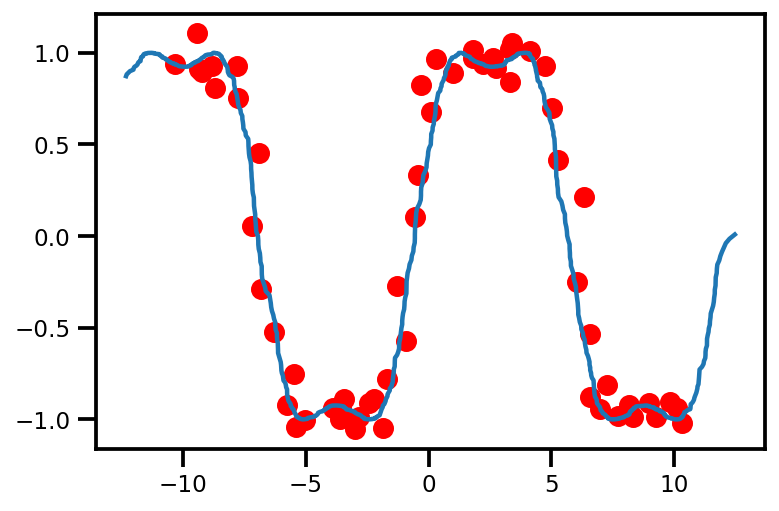

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [21]:
# initialize kernel
kernel = RBF(length_scale=0.01, variance=1.0)
# kernel = RationalQuadratic()

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RBF).variance [1.]
(ExactGP).kernel(RBF).length_scale [0.01]
(ExactGP).noise [0.1]


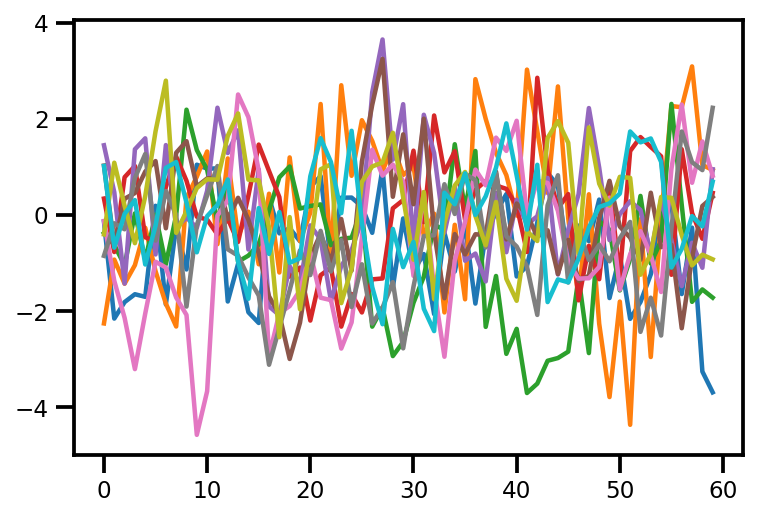

In [22]:
# generate random samples
model_dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = model_dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [23]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:04<00:00, 212.85it/s, Loss=7.82]


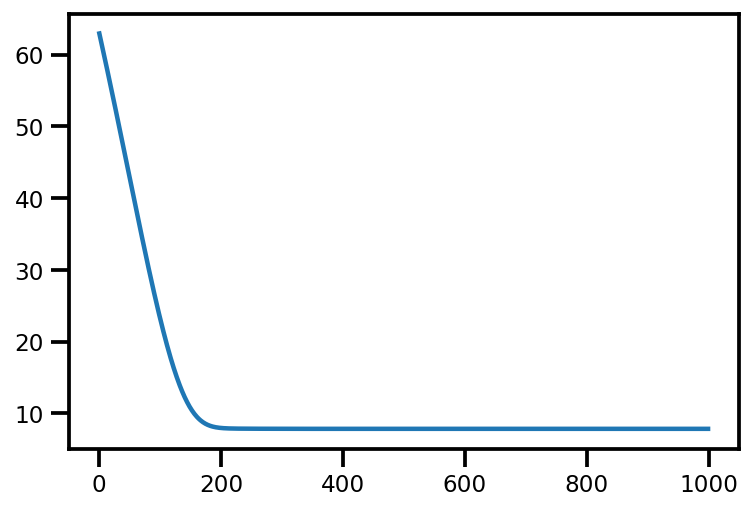

In [24]:
plt.plot(losses)

In [25]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance [-0.02274474] [0.6818394] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RBF).length_scale [1.636864] [1.8146664] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.617682] [0.18095227] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [26]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

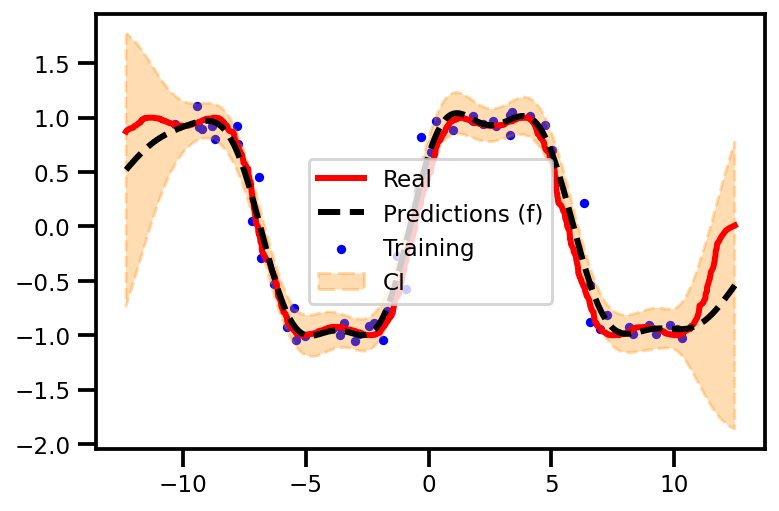

In [27]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, linestyle="--", label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [28]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

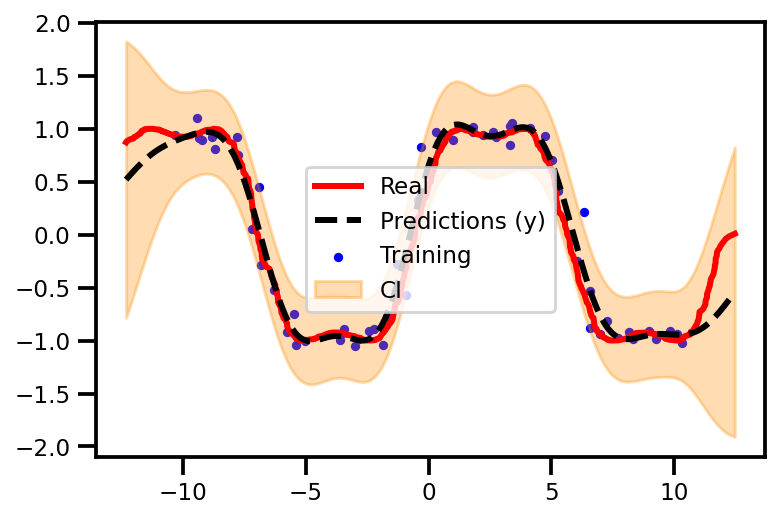

In [29]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Moment-Matching Transformation

In [30]:
from jaxkern.gp.uncertain.moment import (
    MomentMatchingTransform, 
    UnscentedTransform, 
    GaussHermite, 
    SphericalRadialTransform
)

In [31]:
# initialize function
gh_quad = GaussHermite(model, degree=20)

# data
Xtest_cov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))

mm_clf = MomentMatchingTransform(model, GaussHermite, degree=20, jitted=True)
# mm_clf = MomentMatchingTransform(model, SphericalRadialTransform, jitted=True)

In [32]:

mean_mmf, var_mmf = mm_clf.transform(Xtest, Xtest_cov)

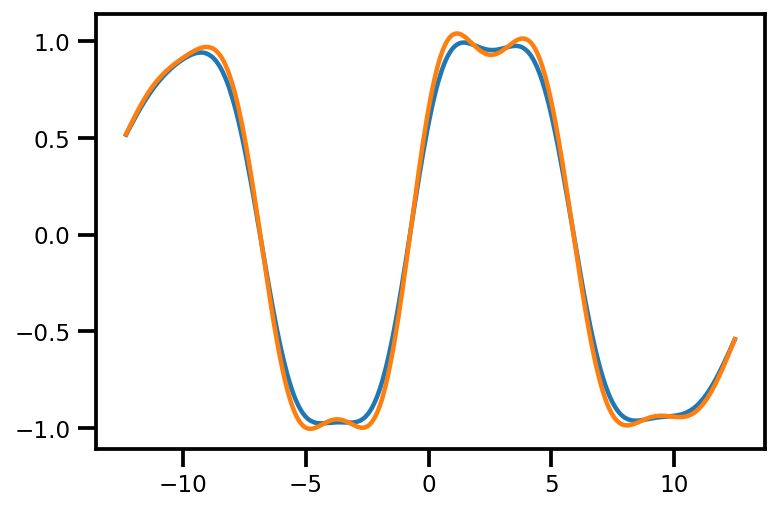

In [33]:
plt.plot(Xtest, mean_mmf)
plt.plot(Xtest, mu)

## Variance

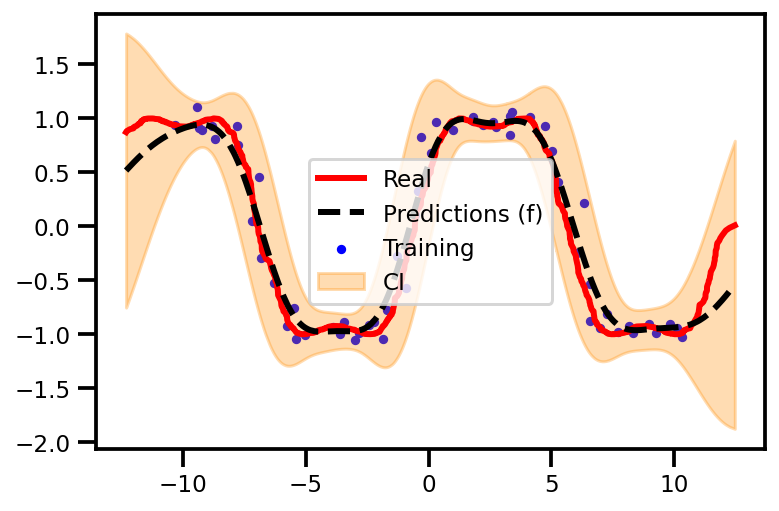

In [34]:
lb, ub = confidence_intervals(mean_mmf, var_mmf, 96)
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_mmf, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

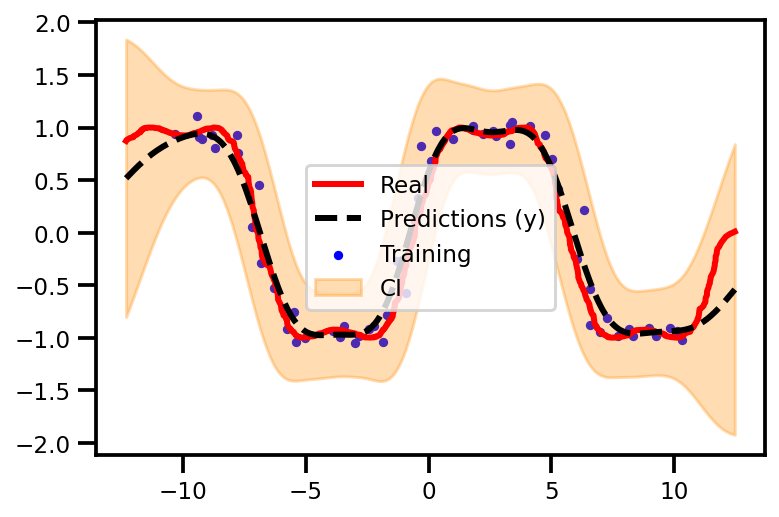

In [35]:
sigma = jax.nn.softplus(model.noise.value)

lb, ub = confidence_intervals(mean_mmf, var_mmf  + sigma ** 2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mean_mmf, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), 
    lb, ub, 
    label='CI', color='darkorange', alpha=0.3
)

plt.legend()